<h1> Implementation of Down-Sampling Methods for Handling Data Imbalance </h1>
<p> Name: Chan Wing Kin (20277087)
<p>Data imbalance may be detrimental to the performance of machine learning algorithms. There are several ways to handle data imbalance issue:</p>
<ul>
    <li>Up Sampling</li>
    <li>Down Sampling</li>
    <li>Modify loss function</li>
</ul>
<p>In this project, several common down sampling techniques will be explored:</p>
<ul>
    <li>Random Down-sampling</li>
    <li>Condensed Nearest Neighbor (CNN) - <i>Hart, P. (1968). The condensed nearest neighbor rule (Corresp.). IEEE transactions on information theory, 14(3), 515-516.</i></li>
    
    <li>Neighborhood Cleaning Rule - <i>Laurikkala, J. (2001, July). Improving identification of difficult small classes by balancing class distribution. In Conference on Artificial Intelligence in Medicine in Europe (pp. 63-66). Springer, Berlin, Heidelberg.</i></li>
    
    <li>TomeK Link + CNN - <i>Kubat, M., & Matwin, S. (1997, July). Addressing the curse of imbalanced training sets: one-sided selection. In ICML (Vol. 97, pp. 179-186).</i></li>
</ul>
<p>In the first section of the project, algorithms will be introduced, following up a study of their behavior through simple randomly generated dataset. Then, algorithms will be tested in datasets from UCI machine learning repository.</p>
<p>Finally, the finding will be discussed to understand/gain insight from these algorithms.</p>

In [1]:
from sklearn.decomposition import PCA
from sklearn.feature_extraction import DictVectorizer
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, KFold
from sklearn.utils import shuffle
import pandas as pd
import numpy as np
from scipy.stats import mode
import random
import seaborn as sns
import pandas as pd
import collections
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, Normalizer

<h3>Helper Functions</h3>

In [2]:
def plot_data(X,y, title = ""):
    x_1 = [sample[0] for sample in X]
    x_2 = [sample[1] for sample in X]
    df = pd.DataFrame()
    df['x_1']=x_1
    df['x_2']=x_2
    df['y']=y
    sns.lmplot(x='x_1', y='x_2', data=df, hue='y', fit_reg = False)
    ax = plt.gca()
    ax.set_title(title)

In [3]:
def shuffle_two_list(X, y):
    temp_zip = list(zip(X,y))
    random.shuffle(temp_zip)
    X, y = zip(*temp_zip)
    return X, y

In [4]:
def get_least_frequent_items(x):
    counter = collections.Counter(x).most_common()
    least_occurence = counter[-1][1]
    return [least_common[0] for least_common in counter if least_common[1]==least_occurence]

In [5]:
def oneHotEncoding(X):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    df = pd.DataFrame(list(zip(*X)))
    dv = DictVectorizer(sparse=False)
    pd_nonnumeric = pd.get_dummies(df[df.isin(df.select_dtypes(exclude=numerics))].dropna(1))
    pd_numeric = pd.get_dummies(df[df.isin(df.select_dtypes(include=numerics))].dropna(1))
    pd_final = pd.concat([pd_nonnumeric, pd_numeric], axis=1, join_axes=[pd_nonnumeric.index])
    final = pd_final.to_dict()
    data = []
    for key, values in final.items():
        datum = []
        for _, value in values.items():
            datum.append(value)
        data.append(datum)
    return list(zip(*data))

In [6]:
def cross_validation(X, y, model, sampling = None, kfold=5):
    print("---------------------------")
    if sampling == None:
        print("With no sampling method...")
    else:
        print("Using {0}...".format(sampling.__name__))
    X = np.array(X)
    y = np.array(y)
    kf = KFold(n_splits=kfold)
    score = 0
    training_size = 0
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        after_training_size = original_training_size = len(X_train)
        if(sampling!=None):
            X_train, y_train = sampling(X_train, y_train)
            after_training_size = len(X_train)
        training_size += 100*after_training_size/original_training_size
        model.fit(X_train, y_train)
        score += model.score(X_test, y_test)
    print("Percentage retained: {0}%".format(training_size/kfold))

    return score/float(kfold)

<h3>Random Down-sampling</h3>

<p>Random down-sampling is the simpliest down-sampling technique commonly used in data balancing.</p>
<p>It has demonstrated excellent performance in different tasks when the data size is large and the imbalance is not too extreme. </p>
<p>Random down-sampling picks the least frequent(minority) class(es), then keep all the minority class while randomly picking same number of data from the majority class, achieving the same number of samples from both the majority and minority classes. </p>

In [7]:
def random_downdsampling(X,y):
    X = list(X)
    y = list(y)
    minority = set([y_i for y_i in y if y_i in get_least_frequent_items(y)])
    max_count = 0
    for minClass in minority:
        if y.count(minClass) > max_count:
            max_count = y.count(minClass)
    X_downsampled = [X_i for idx, X_i in enumerate(X) if y[idx] in minority]
    y_downsampled = [y_i for y_i in y if y_i in minority]
    for classCurrent in set(y):
        max_count_current = max_count
        if classCurrent not in minority:
            for(X_i, y_i) in zip(X,y):
                if(y_i==classCurrent and max_count_current > 0):
                    X_downsampled.append(X_i)
                    y_downsampled.append(y_i)
                    max_count_current -= 1
            
    return X_downsampled, y_downsampled

<h3>Condensed Nearest Neighbor (CNN)</h3>

<p> Condensed Nearest Neighbor is a algorithm originally designed for getting a consistent dataset by extracting meaningful samples from the original data. Later it was being modified for data balancing and the algorithm is the follow:</p>
<ol>
    <li>Collect all the minority examples into "Store".</li>
    <li>Classify other examples with "Store" by 1NN.</li>
    <li>If classify correctly, ignore the example. If classify incorrectly, add the example into "Store" to classify other examples.</li>
    <li>Return "Store" as the selected examples.</li>
</ol>
    
<p><b>Reference:</b></p>
<p>Hart, P. (1968). The condensed nearest neighbor rule (Corresp.). IEEE transactions on information theory, 14(3), 515-516.</p>

In [8]:
#Support multiple minorClass - take minorClass as a list input 
def condensed_NN_balancing(X, y, minorClass = None, random_state = 0):
    X,y = shuffle_two_list(X,y)
    if minorClass == None:
        least_frequent_items = get_least_frequent_items(y)
        #print("Finding least frequent items...")
        #print("Add it(them) to the minorClass...")
        minorClass = least_frequent_items
        
    index_minorClass = [index for index, y_i in enumerate(y) if y_i in minorClass]
    
    X_tuple, y_tuple = zip(*[(X[idx], y[idx]) for idx in index_minorClass])
    X_store = list(X_tuple)
    y_store = list(y_tuple)
    #plot_data(X_store, y_store)
    KN_clf = KNeighborsClassifier(n_neighbors=1)
    KN_clf.fit(X_store, y_store)
    for X_i, y_i in zip(X,y):
        if(y_i not in minorClass and KN_clf.predict([X_i])!=y_i):
            X_store.append(X_i)
            y_store.append(y_i)
            KN_clf.fit(X_store, y_store)
    
    return X_store, y_store

<h3> CNN + Tomelink</h3>

<p> CNN algorithm described above may help to purify the examples. However, some examples in the decision boundary maybe noisey, leading to undesirable performance of NN classifier near the boundary.</p>
<p>Tomelink is a measure captures whether a sample is noisey. To determine whether a sample is participated in Tomelink or not, one may reference to the paper mentioned below.</p>
<p>Here is the algorithm:</p>
<ol>
    <li>Let S be the original training set.</li>
    <li>Initially, C contains all positive examples from S and one randomly selected negative example.</li>
    <li>Classify S with the 1-NN rule using the examples in C, and compare the assigned concept labels with the original ones. Move all misclassified examples into C that is now consistent with S while being smaller.</li>
    <li>Remove from C all negative examples participating in Tomek links. This removes those negative examples that are believed borderline and/or noisy. All positive examples are retained. The resulting set is referred to as T.</li>
</ol>


<p><b>Reference:</b></p>
<p>Kubat, M., & Matwin, S. (1997, July). Addressing the curse of imbalanced training sets: one-sided selection. In ICML (Vol. 97, pp. 179-186).</p>

In [9]:
def TomekLinkSelection(X, y, metric='l2', random_state = 0):
    minority = [y_i for y_i in set(y) if y_i in get_least_frequent_items(y)]

    sample_index = []
    positive_index = []
    for index, y_value in enumerate(y):
        if(y_value in minority):
            positive_index.append(index)
    sample_index = positive_index
    while True:
        random_negative_index = random.randint(0, len(y)-1)
        if(random_negative_index not in sample_index):
            sample_index.append(random_negative_index)
            break
   
    training_samples_X = [X[index] for index in sample_index]
    training_samples_y = [y[index] for index in sample_index]
    #plot_data(training_samples_X,training_samples_y, title="Positive Example w/ One Negative Example")
    
    
    
    misclassified_index = []
    KN_clf = KNeighborsClassifier(n_neighbors=1)
    KN_clf.fit(training_samples_X,  training_samples_y)
    KN_clf_pred =  KN_clf.predict(X)
    for index, result in enumerate(KN_clf_pred):
        if(y[index]!=result):
            misclassified_index.append(index)

    C = sample_index + misclassified_index
    
    C_X = [X[index] for index in C]
    C_y = [y[index] for index in C]
    #plot_data(C_X,C_y, title="Previous Graph with Misclassified Data Points")
    
    
    kneighbor = NearestNeighbors(n_neighbors=2)
    kneighbor.fit(X)
    kneighbors = [neighbor[1] for neighbor in kneighbor.kneighbors(X)[1]]
    
    
    tomek_link_index = []
    for index, neighbor_index in enumerate(kneighbors):
        if(kneighbors[neighbor_index] == index and y[neighbor_index] != y[index]):
            tomek_link_index.append(index)
    #print(tomek_link_index)
    X_T = [X[index] for index in C if (index in positive_index or index not in tomek_link_index)]
    y_T = [y[index] for index in C if (index in positive_index or index not in tomek_link_index)]

    return X_T, y_T

<h3>Neighborhood Cleaning Rule (NCR)</h3>

<p>This method is devised after the appearance of CNN and CNN + Tomelink.</p>
<p>Instead of conducting data reduction (like CNN) and data cleaning (like Tomelink), NCR focus on doing data cleaning. It is believed that the accuracy of model depends on the noiseness of data instead of number of data.</p>
<p>Here is the algorithm of NCR:</p>
<ol>
    <li>Split the data into class of interest C and the rest of data O.</li>
    <li>Identify noisy data A_1 in O with edited nearest neighbor rule.</li>
    <li>For each class C_i in O, if (for x in C in 3NN of misclassified y in C)
        and (|C_i| >= 0.5 |C|) then A_2 = {x} or A_2</li>
    <li>Reduced data S = T - (A_1 or A_2)</li>
</ol>

<p><b>Reference:</b></p>
<p>Laurikkala, J. (2001, July). Improving identification of difficult small classes by balancing class distribution. In Conference on Artificial Intelligence in Medicine in Europe (pp. 63-66). Springer, Berlin, Heidelberg.</p>

In [10]:
def NeighborCleaningRule(X, y, minorClass=None, metric='l2', random_state = 0):
    X = list(X)
    y = list(y)
    if(minorClass==None):
        least_frequent_items = get_least_frequent_items(y)
        if(len(least_frequent_items)==1):
            #print("Found a least frequent item...")
            #print("Setting it as minority class...")
            minorClass = least_frequent_items[0]
        else:
            #print("Found multiple least frequent items...")a
            #print("Randomly pick one as the minority class...")
            minorClass = least_frequent_items[random.randint(0, len(least_frequent_items)-1)]
    index_minorClass = [index for index, x in enumerate(X) if y[index] == minorClass]
    
    #Get class values with |Minor Class| * 0.5 > |Class_i|
    class_value = set(y)
    weak_class = []
    minorClass_count = y.count(minorClass)
    for value in class_value:
        if y.count(value) < 0.5 * minorClass_count:
            weak_class.append(value)

    misclassified_index = []
    KN_clf = KNeighborsClassifier(n_neighbors=3)
    KN_clf.fit(X, y)
    KN_clf_pred =  KN_clf.predict(X)
    for index, result in enumerate(KN_clf_pred):
        if(y[index]!=result):
            misclassified_index.append(index)
    A_1 = [index for index, X_item in enumerate(X) 
           if (y[index]!=KN_clf_pred[index] and y[index] != minorClass)]
    A_2 = []
    for index in index_minorClass:
        if(KN_clf_pred[index]!=y[index]):
            nearest_neighbor_index = list(KN_clf.kneighbors([X[index]], 
                                          n_neighbors=4, 
                                          return_distance=False)[0])
            try:
                nearest_neighbor_index.remove(index)
            except:
                pass
            A_2 += [i for i in nearest_neighbor_index if (y[i] not in weak_class and y[i]!=minorClass)]
    S_index = set(range(len(X))).difference(set(A_1 + A_2))
    
    X_T = [X[index] for index in S_index]
    y_T = [y[index] for index in S_index]
    return X_T, y_T

<h3>Artificially Generated Data</h3>

<p>To visualize the selection rule, two sets of normally distributed data is generated and assign into different classes.</p>
<p>The visualization enables us to understand how these selection rules select a subset of samples intuitively.</p>

In [11]:
number_of_entry = 160
X = [[random.gauss(2,0.1),random.gauss(2,0.4)] for i in range(int(2*number_of_entry/8)) ]
X += [[random.gauss(2,0.1),random.gauss(3,0.4)] for i in range(int(6*number_of_entry/8))]
y = [0 if i >=number_of_entry/4 else 1 for i in range(number_of_entry)]

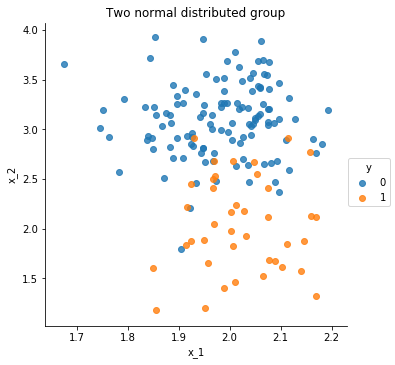

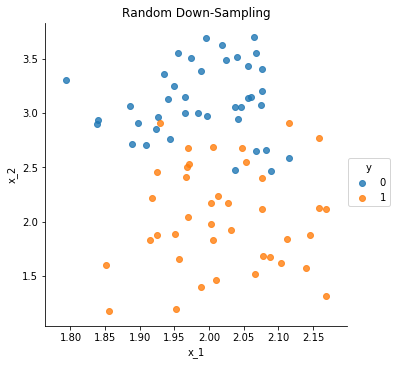

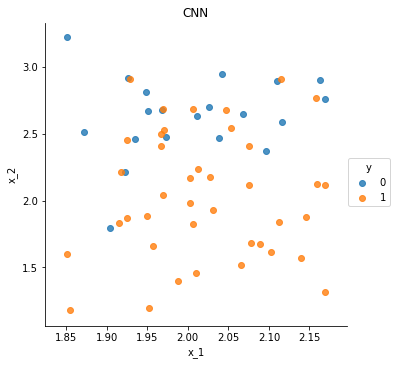

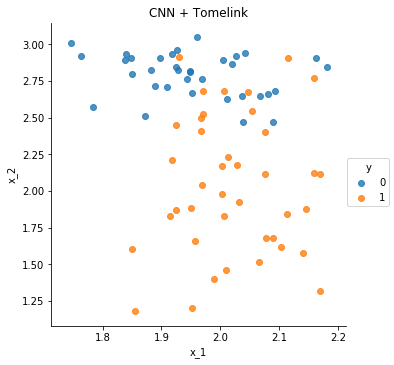

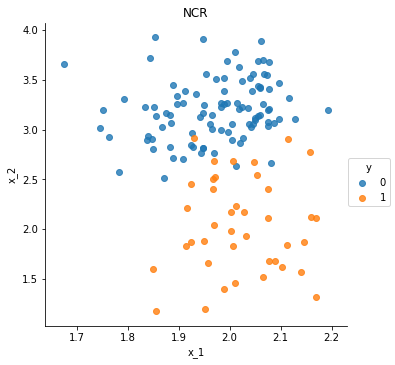

In [12]:
plot_data(X,y, "Two normal distributed group")
X_ran, y_ran = random_downdsampling(X,y)
plot_data(X_ran, y_ran, "Random Down-Sampling")
X_cnn, y_cnn = condensed_NN_balancing(X,y)
plot_data(X_cnn, y_cnn, "CNN")
X_tom, y_tom = TomekLinkSelection(X,y)
plot_data(X_tom, y_tom, "CNN + Tomelink")
X_ncr, y_ncr = NeighborCleaningRule(X,y)
plot_data(X_ncr, y_ncr, "NCR")

<p> From the above result, it can be clearly seen that:</p>
<ol>
    <li>Random down-sampling removed majority samples randomly and does show any specific pattern.</li>
    <li>CNN clear out the majority group except those near the boundary, and it does not remove noisy data in the decision boundary</li>
    <li>CNN + Tomelink removes not only examples from majority class which are away from the decision boundary, but also remove noisy data near the decision boundary</li>
    <li>NCR clears mainly noisy data near the decision boundary</li>
</ol>
<p>The visualization aligns with the understanding of algorithms stated above.</p>

<h3>Testing on UCI Machine Learning Repository Data</h3>

<p> UCI Machine Learning Repository provides different data for testing out machine learning algorithms. In here, few classification tasks with imbalance data are selected to test the data selection algorithms.</p>
<p>Here are the selected dataset from UCI:</p>
<ul>
    <li> Statlog (German Credit Data) Data Set - Class % (30.00%, 70.00%)</li>
    <li> Nursery Data Set - Class % (33.33%, 66.66%)</li>
    <li> SPECT Heart Data Set - Class % (20.60%, 79.40%)</li>
</ul>
<p> The following preprocessing are done to improve the accuracy and consistency of data:</p>
<ul>
    <li>One hot encoding for categorical classes with no intrinsic ordering</li>
    <li>Label encoding for categorical classes with intrinsic ordering</li>
    <li>Max-Min normalization for all features</li>
</ul>

In [13]:
def testClassifier(X, y, classifier):
    print("Accuracy: ", cross_validation(X, y, knn_clf, kfold=5))
    print("Accuracy: ", cross_validation(X, y, knn_clf, condensed_NN_balancing, kfold=5))
    print("Accuracy: ", cross_validation(X, y, knn_clf, TomekLinkSelection, kfold=5))
    print("Accuracy: ", cross_validation(X, y, knn_clf, NeighborCleaningRule, kfold=5))
    print("Accuracy: ", cross_validation(X, y, knn_clf, random_downdsampling, kfold=5))

<h3>Statlog (German Credit Data) Data Set - Class % (30.00%, 70.00%)</h3>

In [14]:
german_data = []
with open('./dataset/german.data.txt', 'r') as f:
    data = f.readlines()
    for datum in data:
        datum = datum.strip()
        german_data.append(datum.split(' '))
    german_data = list(zip(*german_data))
for index, column in enumerate(german_data):
    if column[0].isdigit():
        german_data[index] = [int(value) for value in column]

In [15]:
(german_data_X, german_data_y) = (german_data[:-1], german_data[-1])
german_data_X = oneHotEncoding(german_data_X)
scaler = MinMaxScaler()
german_data_X_minmax = scaler.fit_transform(german_data_X)

In [16]:
print("Statlog (German Credit Data) Data Set - Class % (30.00%, 70.00%)")
X = german_data_X_minmax
y = german_data_y
knn_clf = KNeighborsClassifier(n_neighbors=20)
testClassifier(X, y, knn_clf)

Statlog (German Credit Data) Data Set - Class % (30.00%, 70.00%)
---------------------------
With no sampling method...
Percentage retained: 100.0%
Accuracy:  0.726
---------------------------
Using condensed_NN_balancing...
Percentage retained: 63.375%
Accuracy:  0.6970000000000001
---------------------------
Using TomekLinkSelection...
Percentage retained: 94.75%
Accuracy:  0.7300000000000001
---------------------------
Using NeighborCleaningRule...
Percentage retained: 74.675%
Accuracy:  0.705
---------------------------
Using random_downdsampling...
Percentage retained: 60.0%
Accuracy:  0.695


<h3>Analysis - German Credit Data</h3>

<p>The performance of CNN, NCR and random down sampling are very similar. It is interesting to note that for CNN and random downsampling, they retains around 60% of the original data while only sacrificing only 2% of accuracy.</p>
<p>The most interesting result if from TomekLinkSelection (Tomeklink + CNN). It improves the result by 0.5% while reducing the number of examples by 5%. It may be related to removal of noisy of boundary by Tomeklink for this dataset.</p>

<h3>Nursery Data Set - Class % (33.33%, 66.66%)</h3>

In [17]:
nursery_data = []
with open('./dataset/nursery.data.txt', 'r') as f:
    data = f.readlines()
    for datum in data:
        datum = datum.strip()
        datum = datum.split(',')
        if(len(datum)==9):
            nursery_data.append(datum)
    nursery_data = list(zip(*nursery_data))
for index, column in enumerate(nursery_data):
    if column[0].isdigit() and index!=3:
        nursery_data[index] = [int(value) for value in column]
    elif index == 3:
        nursery_data[index]=[int(value) if value.isdigit() else 4 for value in column]


In [18]:
nursery_data_X = nursery_data[:-1]
nursery_data_y = nursery_data[-1]

In [19]:
le_0 = preprocessing.LabelEncoder()
le_0.fit(["usual", "pretentious", "great_pret"])
nursery_data_X[0] = list(le_0.transform(nursery_data_X[0]))

le_1 = preprocessing.LabelEncoder()
le_1.fit(['proper', 'less_proper', 'improper', 'critical', 'very_crit'])
nursery_data_X[1] = list(le_1.transform(nursery_data_X[1]))


le_2 = preprocessing.LabelEncoder()
le_2.fit(['complete', 'completed', 'incomplete', 'foster'])
nursery_data_X[2] = list(le_2.transform(nursery_data_X[2]))

le_4 = preprocessing.LabelEncoder()
le_4.fit(['convenient', 'less_conv', 'critical'])
nursery_data_X[4] = list(le_4.transform(nursery_data_X[4]))

le_5 = preprocessing.LabelEncoder()
le_5.fit(['convenient', 'inconv'])
nursery_data_X[5] = list(le_5.transform(nursery_data_X[5]))

le_6 = preprocessing.LabelEncoder()
le_6.fit(['nonprob', 'slightly_prob', 'problematic'])
nursery_data_X[6] = list(le_6.transform(nursery_data_X[6]))

le_7 = preprocessing.LabelEncoder()
le_7.fit(['recommended', 'priority', 'not_recom'])
nursery_data_X[7] = list(le_7.transform(nursery_data_X[7]))

nursery_data_y = ['recommend' if y_i !='not_recom' else 'not_recom' for y_i in nursery_data_y]

In [20]:
nursery_data_X = list(zip(*nursery_data_X))

In [21]:
scaler = MinMaxScaler()
nursery_data_X_minmax = scaler.fit_transform(nursery_data_X)
X = nursery_data_X_minmax
y = nursery_data_y
knn_clf = KNeighborsClassifier(n_neighbors=5)
print("Nursery Data Set - Class % (33.33%, 66.66%)")
testClassifier(X, y, knn_clf)

Nursery Data Set - Class % (33.33%, 66.66%)
---------------------------
With no sampling method...
Percentage retained: 100.0%
Accuracy:  1.0
---------------------------
Using condensed_NN_balancing...
Percentage retained: 38.89660493827161%
Accuracy:  0.9720679012345679
---------------------------
Using TomekLinkSelection...
Percentage retained: 97.89351851851852%
Accuracy:  1.0
---------------------------
Using NeighborCleaningRule...
Percentage retained: 100.0%
Accuracy:  1.0
---------------------------
Using random_downdsampling...
Percentage retained: 66.66666666666667%
Accuracy:  0.9135030864197532


<h3>Analysis - Nursery Data Set</h3>

<p>Performance of CNN in this example is outstanding - it reduced the sample by 61.15% while retaining an accuracy of 97.1%. It indicates that the majority class has a lot of redundunt examples and examples have a clear decision boundary. </p>
<p>For NCR, it has nothing interesting since no examples are removed. When considering how the algorithm works, it may be inferred that the dataset's decision boundary are well separated in this dataset.</p>
<p>The inference above is again supported by the TomekLinkSelection, where only small among of data is removed, which mostly are noisy examples on the decision boundary.</p>
<p>Finally, for random down-sampling, it retains 66.7% of the data but sacrificed 8.6% of accuracy, which is not performing well when comparing with other methods. As been discussed above, the decision boundary itself may be well-separated, random sampling may lead to a boundary shift, bringing detrimental effects to the prediction accuracy.</p>

<h3>SPECT Heart Data Set - Class % (20.60%, 79.40%)</h3>

In [22]:
SPECT_data = []
for file_name in ['test', 'train']:
    with open('./dataset/SPECT.{0}.txt'.format(file_name), 'r') as f:
        data = f.readlines()
        for datum in data:
            datum = datum.strip()
            datum = datum.split(',')
            SPECT_data.append(datum)
SPECT_data = list(zip(*SPECT_data))

SPECT_data_y = SPECT_data[0]
SPECT_data_X = list(zip(*SPECT_data[1:]))
SPECT_data_X, SPECT_data_y = shuffle(SPECT_data_X, SPECT_data_y)

In [23]:
scaler = MinMaxScaler()
SPECT_data_X_minmax = scaler.fit_transform(SPECT_data_X)
X = SPECT_data_X
y = SPECT_data_y
knn_clf = KNeighborsClassifier(n_neighbors=5)
print("SPECT Heart Data Set - Class % (20.60%, 79.40%)")
testClassifier(X, y, knn_clf)


SPECT Heart Data Set - Class % (20.60%, 79.40%)
---------------------------
With no sampling method...
Percentage retained: 100.0%
Accuracy:  0.8049615653389239
---------------------------
Using condensed_NN_balancing...
Percentage retained: 54.494756702207006%
Accuracy:  0.7562543675751222
---------------------------
Using TomekLinkSelection...
Percentage retained: 93.73085867228292%
Accuracy:  0.7561844863731657
---------------------------
Using NeighborCleaningRule...
Percentage retained: 82.6747400289588%
Accuracy:  0.7526205450733752
---------------------------
Using random_downdsampling...
Percentage retained: 41.196086174367075%
Accuracy:  0.6250873515024459


<h3>Analysis of Results - SPECT Heart Data Set </h3>

<p>For all methods except random down sampling, the performance are similar. There may be few things can be inferred from the result.</p>
<p> First, the CNN, NCR and TomekLinkSelection displays no large differences in prediction accuracy. It might indicates that both certain important examples are lying near the decision boundary and outside the boundary.</p>
<p> It is interesting to note that CNN removed 45% of the examples while reducing 5% accuracy. It can be inferred that most of the example outside the decision boundary is not helpful in classification.</p>
<p>For random down sampling method, it's accuracy are significantly lower than other down sampling methods.</p>

<h3>Conclusion</h3>

<p>Throughout the exploration, there are couple interesting findings:</p>
<ol>
    <li>Random down sampling may serves as a base line for testing other down sampling algorithms.</li>
    <li>Different down sampling techniques may be helpful in understanding the data in high dimension (e.g. understanding the distribution of data near the decision boundary)</li>
    <li>Selection of down sampling algorithms can be based on knowledge of distribution of data</li>
</ol>
<p>All these findings may serve as a guide for exploration of data and data cleaning. As in this project, only KNN algorithm is used to test the sampling algorithms. Further research can be conducted to understand the behavior of algorithms under different machine learning models, hopefully gaining more insight and improving performance of machine learning models.</p>